In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from financepy.models.black import *
from financepy.utils.global_types import *
import MJD as mjd

%load_ext autoreload
%autoreload 2

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
def blackImpliedVol(forward,   # Forward rate F
                    K,         # Strike Rate K
                    T,         # Time to Expiry (years)
                    DF,        # df RFR to expiry date
                    callOrPut, # FinOptionTypes.EUROPEAN_CALL or FinOptionTypes.EUROPEAN_PUT
                    price
                    ):    
    min_ivol, max_ivol = 0.001, 1.0
    f = lambda ivol: Black(ivol).value(forward, K, T, DF, callOrPut) - price    
    return optimize.bisect(f, min_ivol, max_ivol)    

In [3]:
def carr_madan_integrand(cf, logk, u, alpha):
    top = cf(complex(u, -(alpha+1.0))) * np.exp(complex(0.0, -u*logk))
    bottom = complex(alpha*alpha + alpha - u*u, (2.0*alpha + 1.0)*u)
    result = top/bottom
    return result.real 


def heston_cf(forward, vol_0, kappa, var_bar, gamma, rho, t, u):
    # pre computed values
    rliu_m_k = complex(-kappa, rho * gamma * u)
    d = np.sqrt( rliu_m_k * rliu_m_k + complex(gamma*gamma*u*u, gamma*gamma*u) )
    k_m_rliu_m_d = complex(kappa, -rho * gamma * u) - d
    g2 = complex(kappa-d, -rho*gamma*u) / complex(kappa+d, -rho*gamma*u)
    emdt = np.exp(-d*t)
    one_m_g2 = 1.0 - g2 * emdt
    one_m_emdt = 1.0 - emdt
    v0v0ll = vol_0*vol_0/(gamma*gamma)
    temp1 = np.exp(complex(0.0, u * np.log(forward)))
    temp2 = k_m_rliu_m_d*t - 2.0 * np.log (one_m_g2/(1.0-g2))
    temp2 = np.exp( temp2 * var_bar*kappa/(gamma*gamma) )
    temp3 = np.exp( v0v0ll * k_m_rliu_m_d * (1.0 - emdt) / one_m_g2 )
    result = temp1 * temp2 * temp3
    return result

#vol_0,    # the volatility at time 0, NOT variance
#kappa,    # mean reversion rate
#var_bar,  # mean reversion level
#gamma,    # vol of variance
#rho,      # correlation 
def carr_madan_heston_call_option(forward, vol_0, kappa, var_bar, gamma , rho, t, k, r, alpha = 0.75):
    cf = lambda u: heston_cf(forward, vol_0, kappa, var_bar, gamma, rho, t, u)
    integrand = lambda u: carr_madan_integrand(cf, np.log(k), u, alpha)
    result, error = integrate.quad(integrand, 0.0, np.inf)
    return np.exp(-r*t) * np.exp(-alpha*np.log(k)) / np.pi * result

### Different maturities

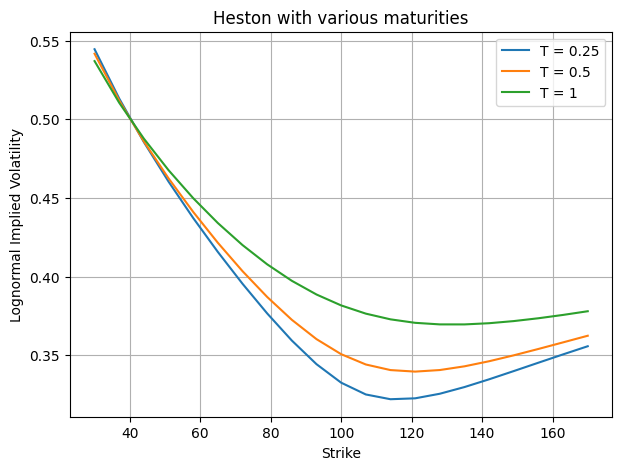

In [4]:
var_0 = 0.0989   # variance at time 0
mean_rev_speed = 0.7331  #a
mean_rev_level = 0.3407  #V bar
vol_of_var = 0.7  #nu
corr = -0.2949     #rho
vol_0 = np.sqrt(var_0)
S0 = 100
Ts = [0.25, 0.5, 1]
rs = [0, 0, 0]
Ks = np.linspace(30, 170, 21)
callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks

for r, T in zip(rs, Ts):    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    call_values = [carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K, r) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, Ks)]       
    df['T = ' + str(T)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Heston with various maturities")
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigHeston1.png")
plt.show()

### Different Var_0

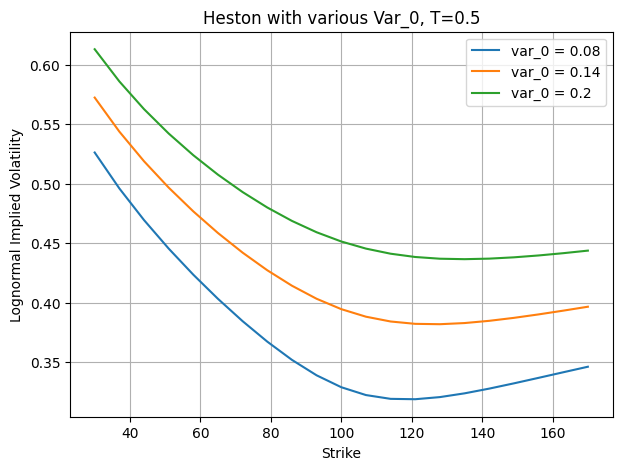

In [5]:
var_0s = [0.08, 0.14, 0.2]
mean_rev_speed = 0.7331  #a
mean_rev_level = 0.3407  #V bar
vol_of_var = 0.7  #nu
corr = -0.2949     #rho

S0, T, r = 100, 0.5, 0
Ks = np.linspace(30, 170, 21)

df = pd.DataFrame()
df['Strike'] = Ks

for var_0 in var_0s:    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    vol_0 = np.sqrt(var_0)
    call_values = [carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K, r) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, Ks)]       
    df['var_0 = ' + str(var_0)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Heston with various Var_0, T=0.5")
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigHeston2.png")
plt.show()

### Different Mean Rev Speed

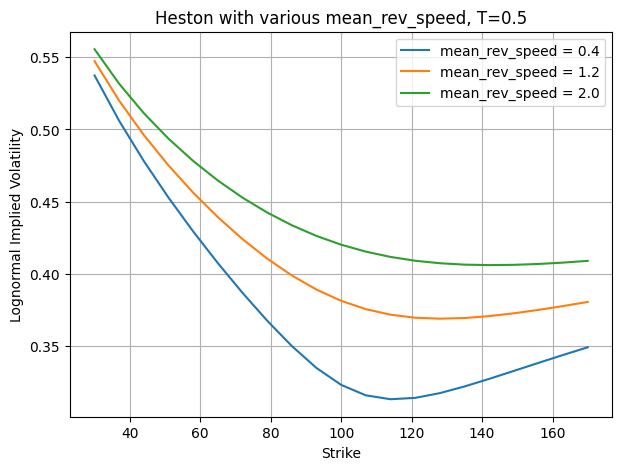

In [6]:
var_0 = 0.0989   # variance at time 0
vol_0 = np.sqrt(var_0)
mean_rev_speeds = np.linspace(0.4, 2.0, 3)
mean_rev_level = 0.3407  #V bar 
vol_of_var = 0.7  #nu  
corr = -0.2949     #rho

S0, T, r = 100, 0.5, 0
Ks = np.linspace(30, 170, 21)
callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks

for mean_rev_speed in mean_rev_speeds:    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    
    call_values = [carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K, r) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, Ks)]       
    df['mean_rev_speed = ' + str(round(mean_rev_speed,1))] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Heston with various mean_rev_speed, T=0.5")
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigHeston3.png")
plt.show()

### Different Mean Rev Level

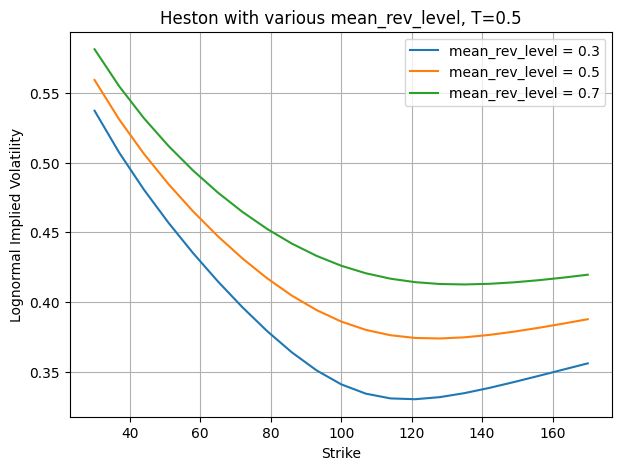

In [7]:
var_0 = 0.0989   # variance at time 0
vol_0 = np.sqrt(var_0)
mean_rev_speed = 0.7331
mean_rev_levels = [0.3, 0.5, 0.7]
vol_of_var = 0.70  #nu  
corr = -0.2949     #rho

S0, T, r = 100, 0.5, 0
Ks = np.linspace(30, 170, 21)
callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks

for mean_rev_level in mean_rev_levels:    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    
    call_values = [carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K, r) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, Ks)]       
    df['mean_rev_level = ' + str(mean_rev_level)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Heston with various mean_rev_level, T=0.5")
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigHeston4.png")
plt.show()

### Different volatility of variance

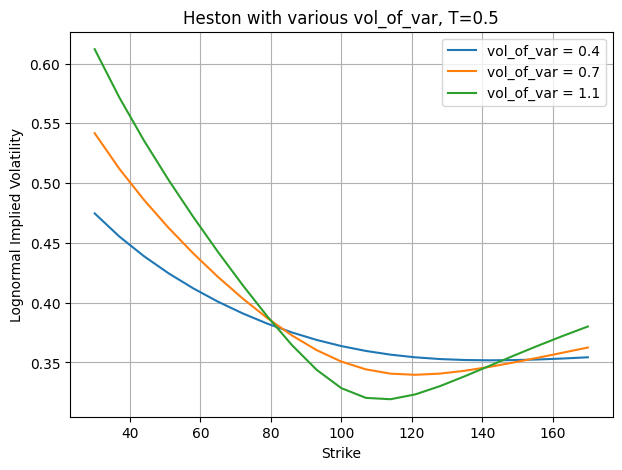

In [8]:
var_0 = 0.0989   # variance at time 0
vol_0 = np.sqrt(var_0)
mean_rev_speed = 0.7331
mean_rev_level = 0.3407
vol_of_vars = [0.4, 0.7, 1.1]
corr = -0.2949     #rho

S0, T, r = 100, 0.5, 0
Ks = np.linspace(30, 170, 21)
callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks

for vol_of_var in vol_of_vars:    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    
    call_values = [carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K, r) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, Ks)]       
    df['vol_of_var = ' + str(vol_of_var)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Heston with various vol_of_var, T=0.5")
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigHeston5.png")
plt.show()

### Different correlations

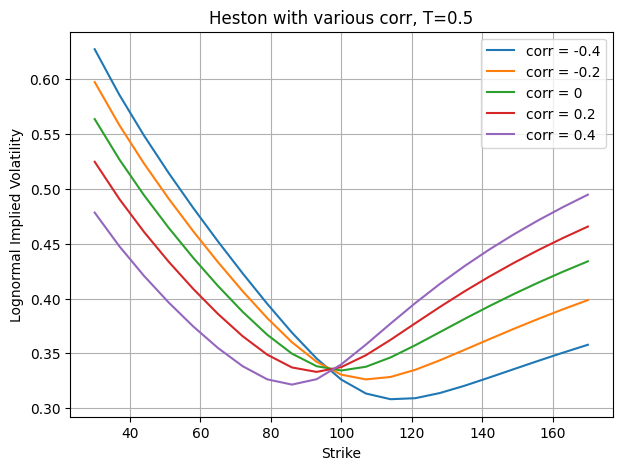

In [9]:
var_0 = 0.0989   # variance at time 0
vol_0 = np.sqrt(var_0)
mean_rev_speed = 0.7331
mean_rev_level = 0.3407
vol_of_vars = 0.7
corrs = [-0.4, -0.2, 0, 0.2, 0.4]

S0, T, r = 100, 0.5, 0
Ks = np.linspace(30, 170, 21)
callOrPut = OptionTypes.EUROPEAN_CALL

df = pd.DataFrame()
df['Strike'] = Ks

for corr in corrs:    
    DF = np.exp(-r*T)
    forward = S0 * np.exp(r*T)
    
    call_values = [carr_madan_heston_call_option(forward, vol_0, mean_rev_speed, mean_rev_level, vol_of_var, corr, T, K, r) for K in Ks]      
    ivols = [blackImpliedVol(forward, K, T, DF, callOrPut, call_value) for call_value, K in zip(call_values, Ks)]       
    df['corr = ' + str(corr)] = np.array(ivols)

df = df.set_index('Strike')
df.plot(grid=True, figsize=(7, 5))
plt.title("Heston with various corr, T=0.5")
plt.xlabel("Strike")
plt.ylabel("Lognormal Implied Volatility")

#plt.savefig("L4_FigHeston6.png")
plt.show()